In [171]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
sns.set(font_scale=1.5)

In [172]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [173]:
data = pd.read_csv ("Dati_Scania_status.csv")
data.shape

(404892, 19)

In [174]:
data = data.drop_duplicates().reset_index().drop(columns=['index'])
data.shape

(120269, 19)

## FEATURE ENGINEERING

In [175]:
data = data.sort_values(by=['LicensePlate', 'CreatedDateTime'])
data['day'] = data['CreatedDateTime'].str[:10]

df_tot = pd.DataFrame()

for name in set(data['LicensePlate']):
    df_truck = data[data['LicensePlate']==name]
    df_truck = df_truck[['day', 'Heading', 'Altitude', 'Speed', 'HRTotalVehicleDistance', 'EngineTotalFuelUsed',
                        'FuelLevel1', 'CatalystFuelLevel']]
    df_gb = df_truck.groupby('day').agg(['max', 'min', 'mean', 'std', lambda x: rms(x), lambda x: skew(x), lambda x: kurtosis(x)]).rename(columns={'<lambda_0>': 'rms', '<lambda_1>': 'skew', '<lambda_2>': 'kurt'})

    df_gb.columns = list(map('_'.join, df_gb.columns.values))
    df_gb['Truck'] = name
    
    frames = [df_tot, df_gb]
    df_tot = pd.concat(frames)

In [176]:
df_tot

,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_rms,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_mean,...,FuelLevel1_skew,FuelLevel1_kurt,CatalystFuelLevel_max,CatalystFuelLevel_min,CatalystFuelLevel_mean,CatalystFuelLevel_std,CatalystFuelLevel_rms,CatalystFuelLevel_skew,CatalystFuelLevel_kurt,Truck
day,,,,,,,,,,,,,,,,,,,,,
2021-05-20,326.0,326.0,326.000000,0.000000,326.000000,0.000000,-3.000000,42.0,42.0,42.000000,...,0.000000,-3.000000,78,78,78.000000,0.000000,78.000000,0.000000,-3.000000,FV908SK
2021-05-31,286.0,38.0,197.428571,123.316799,230.431893,-0.596285,-1.644444,33.0,6.0,24.428571,...,0.000000,-3.000000,78,78,78.000000,0.000000,78.000000,0.000000,-3.000000,FV908SK
2021-06-01,6.0,6.0,6.000000,0.000000,6.000000,0.000000,-3.000000,66.0,66.0,66.000000,...,0.000000,-3.000000,78,78,78.000000,0.000000,78.000000,0.000000,-3.000000,FV908SK
2021-06-08,141.0,115.0,119.857143,7.177498,120.056534,2.102984,3.453372,63.0,53.0,60.357143,...,0.000000,-3.000000,78,78,78.000000,0.000000,78.000000,0.000000,-3.000000,FV908SK
2021-06-09,304.0,28.0,244.892857,108.993489,267.259839,-1.404657,0.122087,53.0,24.0,49.035714,...,-0.764719,-1.415205,78,78,78.000000,0.000000,78.000000,0.000000,-3.000000,FV908SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-13,352.0,10.0,171.727273,102.610637,199.568945,0.204008,-1.193603,461.0,141.0,207.018182,...,0.414858,-1.232412,99,97,98.963636,0.269680,98.963997,-7.212386,50.018519,FV059FV
2022-01-14,358.0,11.0,168.623188,101.210628,196.287832,0.246721,-1.294604,289.0,121.0,174.608696,...,0.367706,-1.165661,99,83,90.898551,6.949704,91.159996,-0.017360,-1.718797,FV059FV
2022-01-15,354.0,1.0,155.960784,105.036367,187.456871,0.515482,-1.116184,170.0,111.0,143.607843,...,0.647449,-0.609790,84,75,76.803922,3.092052,76.864918,1.423642,0.452015,FV059FV


In [177]:
df_tot['day_distance'] = df_tot['HRTotalVehicleDistance_max'] - df_tot['HRTotalVehicleDistance_min']
df_tot = df_tot.drop(columns=['HRTotalVehicleDistance_min', 'HRTotalVehicleDistance_mean',
                             'HRTotalVehicleDistance_std', 'HRTotalVehicleDistance_rms', 'HRTotalVehicleDistance_skew',
                             'HRTotalVehicleDistance_kurt'])

df_tot['day_fuel_used'] = df_tot['EngineTotalFuelUsed_max'] - df_tot['EngineTotalFuelUsed_min']
df_tot = df_tot.drop(columns=['EngineTotalFuelUsed_max', 'EngineTotalFuelUsed_min', 'EngineTotalFuelUsed_mean',
                             'EngineTotalFuelUsed_std', 'EngineTotalFuelUsed_rms', 'EngineTotalFuelUsed_skew',
                             'EngineTotalFuelUsed_kurt'])

## FEATURE SELECTION

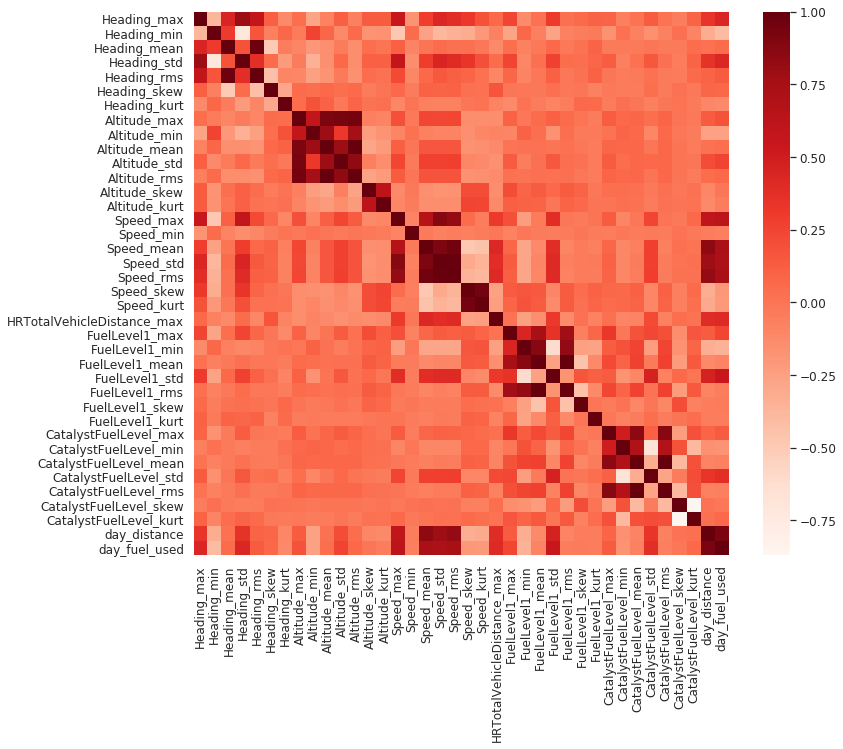

In [178]:
plt.figure(figsize=(12,10))

corr = df_tot.corr()

sns.set(font_scale=1.1)
sns.heatmap(corr, cmap=plt.cm.Reds)

In [179]:
corr = df_tot.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = corr.columns[columns]

df_sel = df_tot[selected_columns].copy()
df_sel['Truck'] = df_tot['Truck']

selected_columns

Index(['Heading_max', 'Heading_min', 'Heading_mean', 'Heading_std',
       'Heading_skew', 'Heading_kurt', 'Altitude_max', 'Altitude_min',
       'Altitude_skew', 'Altitude_kurt', 'Speed_max', 'Speed_min',
       'Speed_mean', 'Speed_skew', 'HRTotalVehicleDistance_max',
       'FuelLevel1_max', 'FuelLevel1_min', 'FuelLevel1_mean', 'FuelLevel1_std',
       'FuelLevel1_skew', 'FuelLevel1_kurt', 'CatalystFuelLevel_max',
       'CatalystFuelLevel_min', 'CatalystFuelLevel_mean',
       'CatalystFuelLevel_std', 'CatalystFuelLevel_skew',
       'CatalystFuelLevel_kurt', 'day_distance'],
      dtype='object')

In [180]:
df_sel = df_sel.reset_index()
df_sel['day'] = pd.to_datetime(df_sel['day'], format='%Y-%m-%d')

df_sel

,day,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,...,FuelLevel1_skew,FuelLevel1_kurt,CatalystFuelLevel_max,CatalystFuelLevel_min,CatalystFuelLevel_mean,CatalystFuelLevel_std,CatalystFuelLevel_skew,CatalystFuelLevel_kurt,day_distance,Truck
0,2021-05-20,326.0,326.0,326.000000,0.000000,0.000000,-3.000000,42.0,42.0,0.000000,...,0.000000,-3.000000,78,78,78.000000,0.000000,0.000000,-3.000000,0,FV908SK
1,2021-05-31,286.0,38.0,197.428571,123.316799,-0.596285,-1.644444,33.0,6.0,-0.780428,...,0.000000,-3.000000,78,78,78.000000,0.000000,0.000000,-3.000000,0,FV908SK
2,2021-06-01,6.0,6.0,6.000000,0.000000,0.000000,-3.000000,66.0,66.0,0.000000,...,0.000000,-3.000000,78,78,78.000000,0.000000,0.000000,-3.000000,0,FV908SK
3,2021-06-08,141.0,115.0,119.857143,7.177498,2.102984,3.453372,63.0,53.0,-0.969063,...,0.000000,-3.000000,78,78,78.000000,0.000000,0.000000,-3.000000,0,FV908SK
4,2021-06-09,304.0,28.0,244.892857,108.993489,-1.404657,0.122087,53.0,24.0,-3.627097,...,-0.764719,-1.415205,78,78,78.000000,0.000000,0.000000,-3.000000,10,FV908SK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2022-01-13,352.0,10.0,171.727273,102.610637,0.204008,-1.193603,461.0,141.0,1.571033,...,0.414858,-1.232412,99,97,98.963636,0.269680,-7.212386,50.018519,108,FV059FV
2197,2022-01-14,358.0,11.0,168.623188,101.210628,0.246721,-1.294604,289.0,121.0,1.130984,...,0.367706,-1.165661,99,83,90.898551,6.949704,-0.017360,-1.718797,179,FV059FV
2198,2022-01-15,354.0,1.0,155.960784,105.036367,0.515482,-1.116184,170.0,111.0,-0.758738,...,0.647449,-0.609790,84,75,76.803922,3.092052,1.423642,0.452015,89,FV059FV
2199,2022-01-17,356.0,47.0,183.634146,89.475068,0.595584,-0.568813,343.0,137.0,0.417355,...,0.185640,-1.291135,75,63,68.780488,5.012545,0.089085,-1.643383,69,FV059FV


## MERGE CON FATTURE

In [181]:
df_fatture = pd.read_excel("fatture_filtered.xlsx")

# Scommentare per considerare solo un particolare gruppo di fatture 
df_fatture = df_fatture[df_fatture['Categoria componente']=='Impianto di lubrificazione motore']

df_fatture = df_fatture[['Targa', 'Data', 'label']]
df_fatture = df_fatture[df_fatture['Targa'].isin(set(df_sel['Truck']))]
len(df_fatture)

7

In [182]:
df_sel['label'] = 0
df_sel = df_sel[df_sel['Truck'].isin(set(df_fatture['Targa']))]
df_sel = df_sel.reset_index(drop=True)

def nearest(items, pivot):
    time = min(items, key=lambda x: abs(x - pivot))
    return pd.to_datetime(time, format='%Y-%m-%d')

In [183]:
from datetime import datetime, timedelta

df_fatture = df_fatture.reset_index(drop=True)
for i in range(df_fatture.shape[0]):
    t = df_fatture['Targa'][i]
    d = df_fatture['Data'][i]
    
    df_truck = df_sel[df_sel['Truck'] == t]
    min_ind = nearest(df_truck['day'], d)
    df_sel.loc[(df_sel['Truck']==t) & (df_sel['day'] == min_ind), 'label'] = 1
    #for i in range(1, h):
    #    df_sel.loc[(df_sel['Truck']==t) & (df_sel['day'] == min_ind-timedelta(days=i)), 'label'] = 1
    
df_sel['label'].value_counts()

0    671
1      7
Name: label, dtype: int64

In [184]:
df_sel['RUL'] = -1
df_damage = df_sel[df_sel['label']==1].copy()
df_damage=df_damage.reset_index(drop=True)

for i in range(df_damage.shape[0]):
    truck = df_damage['Truck'][i]
    day = df_damage['day'][i]
    tot_km = df_damage['HRTotalVehicleDistance_max'][i]
    df_truck = df_sel[(df_sel['Truck']==truck) & (df_sel['day'] <= day)]
    df_sel.loc[(df_sel['Truck']==truck) & (df_sel['day'] <= day) & (df_sel['RUL']==-1), 'RUL'] = tot_km - df_sel['HRTotalVehicleDistance_max']

In [185]:
df_sel=df_sel[df_sel['RUL']!=-1]
df_sel

,day,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,...,CatalystFuelLevel_max,CatalystFuelLevel_min,CatalystFuelLevel_mean,CatalystFuelLevel_std,CatalystFuelLevel_skew,CatalystFuelLevel_kurt,day_distance,Truck,label,RUL
0,2021-05-28,358.0,15.0,172.250000,96.078729,0.003305,-1.009079,57.0,35.0,0.498989,...,100,100,100.000000,0.000000,0.000000,-3.000000,93,FV913SK,0,8349
1,2021-05-29,359.0,16.0,152.644444,98.540291,0.513744,-0.808047,51.0,35.0,-0.102824,...,100,100,100.000000,0.000000,0.000000,-3.000000,85,FV913SK,0,8264
2,2021-05-31,335.0,27.0,174.731343,100.974732,0.070994,-1.153952,55.0,39.0,0.448817,...,100,92,96.791045,2.972283,-0.335961,-1.318946,75,FV913SK,0,8189
3,2021-06-01,335.0,6.0,170.472222,111.830981,0.037575,-1.445922,61.0,37.0,0.054419,...,92,80,87.291667,3.105821,-0.229161,-0.926878,71,FV913SK,0,8118
4,2021-06-02,353.0,7.0,207.509804,109.374105,-0.204356,-1.361867,74.0,40.0,1.289807,...,80,72,77.705882,2.427296,-0.575942,-1.073600,75,FV913SK,0,8043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2021-08-24,346.0,19.0,192.897959,118.342238,-0.422236,-1.581916,80.0,34.0,0.004836,...,98,95,97.408163,0.955649,-1.037304,-0.729555,82,FZ330SC,0,437
593,2021-08-25,358.0,6.0,178.435484,106.652127,0.021656,-1.235197,79.0,33.0,1.653160,...,95,84,90.677419,3.629452,-0.430130,-0.903077,101,FZ330SC,0,336
594,2021-08-26,359.0,4.0,190.328358,103.167470,-0.363516,-1.218541,76.0,34.0,1.337908,...,84,72,78.358209,3.899112,-0.120874,-1.200127,111,FZ330SC,0,225
595,2021-08-27,345.0,4.0,180.276923,102.533913,-0.375861,-1.274725,78.0,38.0,0.675282,...,94,60,71.600000,10.648944,1.433548,0.560183,115,FZ330SC,0,110


In [186]:
df_damage

,day,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,...,CatalystFuelLevel_max,CatalystFuelLevel_min,CatalystFuelLevel_mean,CatalystFuelLevel_std,CatalystFuelLevel_skew,CatalystFuelLevel_kurt,day_distance,Truck,label,RUL
0,2021-09-24,344.0,8.0,156.444444,90.727805,-0.017917,-0.734444,58.0,36.0,0.582516,...,100,100,100.000000,0.000000,0.000000,-3.000000,85,FV913SK,1,-1
1,2021-12-15,349.0,10.0,216.000000,99.834109,-0.236575,-1.215700,179.0,0.0,1.960363,...,91,70,82.000000,6.081636,-0.662943,-0.767819,201,FV914SK,1,-1
2,2021-05-28,309.0,112.0,127.277778,45.493122,3.840039,12.862556,61.0,5.0,-0.921965,...,52,52,52.000000,0.000000,0.000000,-3.000000,10,FV907SK,1,-1
3,2021-07-19,338.0,37.0,217.697674,103.263541,-0.296926,-1.351024,56.0,38.0,0.213698,...,44,40,42.604651,1.575701,-0.804621,-0.921890,58,FV907SK,1,-1
4,2021-05-28,330.0,21.0,205.809524,102.730345,-0.409892,-1.021598,74.0,42.0,0.987867,...,96,88,92.261905,2.705546,-0.154018,-1.127013,76,FZ330SC,1,-1
5,2021-06-30,355.0,3.0,234.205128,98.150608,-0.948248,-0.225043,62.0,41.0,1.568907,...,99,92,96.910256,2.455769,-0.949574,-0.509856,86,FZ330SC,1,-1
6,2021-08-31,346.0,8.0,178.923077,106.976824,-0.095307,-1.526864,87.0,34.0,1.223275,...,100,98,99.538462,0.532592,-0.466271,-1.108661,107,FZ330SC,1,-1


### PREDICTIVE MODEL

In [187]:
df_exp = df_sel.drop(columns=['Truck', 'day', 'label'])
df_exp

,Heading_max,Heading_min,Heading_mean,Heading_std,Heading_skew,Heading_kurt,Altitude_max,Altitude_min,Altitude_skew,Altitude_kurt,...,FuelLevel1_skew,FuelLevel1_kurt,CatalystFuelLevel_max,CatalystFuelLevel_min,CatalystFuelLevel_mean,CatalystFuelLevel_std,CatalystFuelLevel_skew,CatalystFuelLevel_kurt,day_distance,RUL
0,358.0,15.0,172.250000,96.078729,0.003305,-1.009079,57.0,35.0,0.498989,-0.591158,...,0.140870,-0.799651,100,100,100.000000,0.000000,0.000000,-3.000000,93,8349
1,359.0,16.0,152.644444,98.540291,0.513744,-0.808047,51.0,35.0,-0.102824,-1.349625,...,0.441254,-0.963348,100,100,100.000000,0.000000,0.000000,-3.000000,85,8264
2,335.0,27.0,174.731343,100.974732,0.070994,-1.153952,55.0,39.0,0.448817,-0.561405,...,2.130550,5.154921,100,92,96.791045,2.972283,-0.335961,-1.318946,75,8189
3,335.0,6.0,170.472222,111.830981,0.037575,-1.445922,61.0,37.0,0.054419,-0.880321,...,-0.045142,-0.873936,92,80,87.291667,3.105821,-0.229161,-0.926878,71,8118
4,353.0,7.0,207.509804,109.374105,-0.204356,-1.361867,74.0,40.0,1.289807,2.132187,...,-0.039876,-1.151612,80,72,77.705882,2.427296,-0.575942,-1.073600,75,8043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,346.0,19.0,192.897959,118.342238,-0.422236,-1.581916,80.0,34.0,0.004836,-0.535218,...,0.207387,-1.504969,98,95,97.408163,0.955649,-1.037304,-0.729555,82,437
593,358.0,6.0,178.435484,106.652127,0.021656,-1.235197,79.0,33.0,1.653160,2.325627,...,-2.610589,9.158222,95,84,90.677419,3.629452,-0.430130,-0.903077,101,336
594,359.0,4.0,190.328358,103.167470,-0.363516,-1.218541,76.0,34.0,1.337908,1.844519,...,-0.062213,-1.250597,84,72,78.358209,3.899112,-0.120874,-1.200127,111,225
595,345.0,4.0,180.276923,102.533913,-0.375861,-1.274725,78.0,38.0,0.675282,-0.190851,...,1.409138,0.524739,94,60,71.600000,10.648944,1.433548,0.560183,115,110


In [188]:
Y = df_exp['RUL'].copy()
X = df_exp.drop(columns=['RUL'])

In [189]:
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
import warnings
warnings.filterwarnings('ignore')

model = XGBRegressor()
loo = LeaveOneOut()
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error',
                         cv=50, n_jobs=-1)

print("Maximum real RUL: ", df_exp['RUL'].max())
print("Mean real RUL: ", df_exp['RUL'].mean())

print("Mean absolute error: ", mean(absolute(scores)))

Maximum real RUL:  19881
Mean real RUL:  6338.293800539083
Mean absolute error:  1062.0643526404244


### Prediction with only one trucks ###

In [190]:
truck = 'FV913SK'

df_truck = df_sel[df_sel['Truck']== truck]
df_truck = df_truck.drop(columns=['Truck', 'day', 'label'])

In [191]:
Y = df_truck['RUL'].copy()
X = df_truck.drop(columns=['RUL'])

In [192]:
model = XGBRegressor()
loo = LeaveOneOut()
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error',
                         cv=loo, n_jobs=-1)

print("Maximum real RUL: ", Y.max())
print("Mean real RUL: ", Y.mean())

print("Mean absolute error: ", mean(absolute(scores)))

Maximum real RUL:  8349
Mean real RUL:  4111.402173913043
Mean absolute error:  77.9880201920219


### One truck for training and others for test

In [193]:
df_train = df_sel[df_sel['Truck'].isin(['FV913SK'])]
df_train = df_train.drop(columns=['Truck', 'day', 'label'])

In [194]:
df_test = df_sel[df_sel['Truck'].isin(['FV914SK'])]
df_test = df_test.drop(columns=['Truck', 'day', 'label'])

In [195]:
Y_train = df_train['RUL'].copy()
X_train = df_train.drop(columns=['RUL'])

Y_test = df_test['RUL'].copy()
X_test = df_test.drop(columns=['RUL'])

In [197]:
from sklearn.metrics import mean_absolute_error
model = XGBRegressor()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Maximum real RUL: ", Y_test.max())
print("Mean real RUL: ", Y_test.mean())

print("Mean absolute error: ", mean_absolute_error(y_pred, Y_test))

[10:11:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Maximum real RUL:  19881
Mean real RUL:  10249.173184357542
Mean absolute error:  5394.097618060405
